In [1]:
import csv
import math
import random
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
import pickle
from copy import deepcopy

In [2]:
def process_df(df):
  new_df = deepcopy(df)
  new_df["period_index"] = pd.PeriodIndex(df.sale_date, freq="Q")
  new_df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)
  new_df = pd.get_dummies(new_df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
  new_df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)
  return new_df

In [3]:
def train_test_split(df, period):
  train = df[df["period_index"] != period]
  test = df[df["period_index"] == period]
  
  X_train, y_train = train[train.columns.difference(["cpi_psm", "period_index"])], train["cpi_psm"]
  X_test, y_test = test[test.columns.difference(["cpi_psm", "period_index"])], test["cpi_psm"]
  return X_train, X_test, y_train, y_test

In [4]:
PROCESSED_DATA_PATH = os.path.join("../", "../", "data_processed", "resale_flat_prices")
SEED = 42

In [5]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "engineered_data.csv"))
df.head(10)

,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN
3,4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
4,5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
5,6,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,310.344828,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,552.504039,NaN
6,7,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,8.0,7,0.918820,64.0,687.500000,...,1.018641,0.485058,0.986821,0.800866,0.808590,0.940111,1,61.9,1223.949919,NaN
7,8,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,8.0,6,0.920652,74.0,1128.378378,...,1.089870,0.544915,0.567711,0.490547,0.708861,0.799126,1,61.9,2008.841636,NaN
8,9,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,5.0,6,0.920652,73.0,1150.684932,...,1.657478,0.053197,0.982875,0.340834,1.013329,0.940071,1,61.9,2048.553788,NaN
9,10,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,2.0,15,0.902280,76.0,671.052632,...,0.690789,0.083148,0.637859,0.507003,0.406147,1.175060,1,61.9,1194.668821,NaN


In [6]:
df["is_imputted_sora"] = np.where(df["avg_sora"].isnull(), True, False)

imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))

In [7]:
df.describe()

,id,floor,age,relative_tenure,floor_area,psm,latitude,longitude,latitude_rad,longitude_rad,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
count,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,...,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000
mean,432914.000000,7.626058,17.349350,0.892896,96.135123,3173.083607,1.497366,103.148474,0.026134,1.800280,...,62.788172,61.708270,62.231490,61.990540,62.338973,62.217020,190.483063,82.131055,4131.625468,0.763427
std,249942.870098,4.738340,10.217708,0.029046,25.796313,1385.776553,2.612377,11.573640,0.045595,0.201998,...,923.588875,923.284911,923.497181,923.502716,923.385468,923.496916,104.298678,11.879488,1363.166128,0.659903
min,1.000000,2.000000,0.000000,0.731586,28.000000,161.290323,-37.840251,-122.683299,-0.660437,-2.141228,...,0.007724,0.000003,0.000790,0.042886,0.021691,0.018401,1.000000,61.900000,284.387097,0.035633
25%,216457.500000,5.000000,9.000000,0.878870,73.000000,2266.666667,1.335322,103.772049,0.023306,1.811164,...,0.754831,0.076599,0.395358,0.241143,0.477918,0.375599,107.000000,73.400000,3321.083800,0.260618
50%,432914.000000,8.000000,16.000000,0.899953,93.000000,2870.370370,1.355961,103.843296,0.023666,1.812407,...,1.136412,0.112533,0.610644,0.370503,0.705703,0.585058,175.000000,76.500000,4031.953168,0.763427
75%,649370.500000,11.000000,24.000000,0.915007,114.000000,3990.180006,1.383056,103.897860,0.024139,1.813360,...,1.559133,0.156376,0.869802,0.540301,0.994037,0.853369,269.000000,95.900000,4868.754343,0.763427
max,865827.000000,50.000000,55.000000,0.930702,307.000000,13310.344828,50.820779,145.019498,0.886990,2.531068,...,16929.865540,16924.138572,16928.066230,16927.190593,16926.344996,16927.966733,393.000000,110.200000,14163.126574,3.414986


In [8]:
new_df = process_df(df)
sample_values = new_df.sample(frac=0.1, random_state=SEED)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(sample_values, pd.Period(value="2022Q3"))

# GridSearchCV

In [9]:
parameters = {'min_samples_split':[2,5,10,15,20,25,30,35], 'max_depth':range(15, 45, 5), 'min_samples_leaf':[1,2,4,6,8,10,12,14,16]}
grid = GridSearchCV(DecisionTreeRegressor(random_state=SEED, criterion='squared_error'), parameters, scoring='neg_root_mean_squared_error', verbose = 4, return_train_score = True)
grid.fit(X=X_train_sample, y=y_train_sample)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-383.767, test=-487.011) total time=   1.1s
[CV 2/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-386.878, test=-483.616) total time=   1.2s
[CV 3/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-383.901, test=-484.004) total time=   1.2s
[CV 4/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-379.761, test=-492.205) total time=   1.1s
[CV 5/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-384.966, test=-475.530) total time=   1.2s
[CV 1/5] END max_depth=15, min_samples_leaf=1, min_samples_split=5;, score=(train=-386.722, test=-482.383) total time=   1.1s
[CV 2/5] END max_depth=15, min_samples_leaf=1, min_samples_split=5;, score=(train=-389.827, test=-483.709) total time=   1.2s
[CV 3/5] END max_depth=15, min_samples_leaf=1, min_sam

[CV 1/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-411.225, test=-479.407) total time=   1.1s
[CV 2/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-416.478, test=-481.658) total time=   1.1s
[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-412.200, test=-474.673) total time=   1.1s
[CV 4/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-409.966, test=-486.956) total time=   1.1s
[CV 5/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-414.111, test=-471.364) total time=   1.1s
[CV 1/5] END max_depth=15, min_samples_leaf=2, min_samples_split=30;, score=(train=-415.185, test=-479.104) total time=   1.1s
[CV 2/5] END max_depth=15, min_samples_leaf=2, min_samples_split=30;, score=(train=-421.460, test=-481.723) total time=   1.1s
[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=30;, score=(train=-416.780, test=-476.060) tot

[CV 1/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-406.189, test=-484.674) total time=   1.1s
[CV 2/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-409.406, test=-483.120) total time=   1.1s
[CV 3/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-406.166, test=-473.989) total time=   1.1s
[CV 4/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-402.629, test=-486.211) total time=   1.1s
[CV 5/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-406.610, test=-475.010) total time=   1.2s
[CV 1/5] END max_depth=15, min_samples_leaf=6, min_samples_split=15;, score=(train=-408.635, test=-484.488) total time=   1.3s
[CV 2/5] END max_depth=15, min_samples_leaf=6, min_samples_split=15;, score=(train=-412.159, test=-482.979) total time=   1.2s
[CV 3/5] END max_depth=15, min_samples_leaf=6, min_samples_split=15;, score=(train=-409.437, test=-473.744) tot

[CV 1/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-427.884, test=-486.212) total time=   1.0s
[CV 2/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-433.295, test=-487.629) total time=   1.3s
[CV 3/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-427.930, test=-476.524) total time=   1.2s
[CV 4/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-426.494, test=-489.194) total time=   1.1s
[CV 5/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-429.546, test=-474.503) total time=   1.4s
[CV 1/5] END max_depth=15, min_samples_leaf=10, min_samples_split=2;, score=(train=-419.781, test=-483.366) total time=   1.1s
[CV 2/5] END max_depth=15, min_samples_leaf=10, min_samples_split=2;, score=(train=-423.317, test=-489.544) total time=   1.0s
[CV 3/5] END max_depth=15, min_samples_leaf=10, min_samples_split=2;, score=(train=-418.946, test=-478.061) tot

[CV 1/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-426.118, test=-486.980) total time=   1.2s
[CV 2/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-430.441, test=-490.380) total time=   1.1s
[CV 3/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-425.423, test=-479.933) total time=   1.1s
[CV 4/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-424.689, test=-492.065) total time=   1.1s
[CV 5/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-426.855, test=-479.575) total time=   1.1s
[CV 1/5] END max_depth=15, min_samples_leaf=12, min_samples_split=25;, score=(train=-426.622, test=-486.935) total time=   1.2s
[CV 2/5] END max_depth=15, min_samples_leaf=12, min_samples_split=25;, score=(train=-430.872, test=-490.141) total time=   1.1s
[CV 3/5] END max_depth=15, min_samples_leaf=12, min_samples_split=25;, score=(train=-426.097, test=-480.

[CV 1/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-436.456, test=-488.544) total time=   1.2s
[CV 2/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-440.308, test=-492.977) total time=   1.1s
[CV 3/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-436.400, test=-481.832) total time=   1.1s
[CV 4/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-434.238, test=-496.559) total time=   1.1s
[CV 5/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-435.756, test=-482.936) total time=   1.2s
[CV 1/5] END max_depth=15, min_samples_leaf=16, min_samples_split=10;, score=(train=-436.456, test=-488.544) total time=   1.2s
[CV 2/5] END max_depth=15, min_samples_leaf=16, min_samples_split=10;, score=(train=-440.308, test=-492.977) total time=   1.3s
[CV 3/5] END max_depth=15, min_samples_leaf=16, min_samples_split=10;, score=(train=-436.400, test=-481.832) 

[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-338.991, test=-451.629) total time=   1.3s
[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-345.654, test=-449.110) total time=   1.3s
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-340.486, test=-446.883) total time=   1.2s
[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-339.127, test=-455.938) total time=   1.3s
[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-344.345, test=-439.354) total time=   1.3s
[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=35;, score=(train=-347.422, test=-453.804) total time=   1.3s
[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=35;, score=(train=-354.253, test=-449.939) total time=   1.3s
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=35;, score=(train=-349.242, test=-446.053) tot

[CV 1/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-319.739, test=-448.133) total time=   1.3s
[CV 2/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-322.137, test=-451.280) total time=   1.3s
[CV 3/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-319.696, test=-444.673) total time=   1.3s
[CV 4/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-316.558, test=-461.663) total time=   1.3s
[CV 5/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-321.104, test=-446.875) total time=   1.7s
[CV 1/5] END max_depth=20, min_samples_leaf=4, min_samples_split=20;, score=(train=-331.005, test=-448.368) total time=   1.4s
[CV 2/5] END max_depth=20, min_samples_leaf=4, min_samples_split=20;, score=(train=-334.362, test=-450.217) total time=   1.3s
[CV 3/5] END max_depth=20, min_samples_leaf=4, min_samples_split=20;, score=(train=-331.312, test=-441.652) tot

[CV 1/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-338.942, test=-457.953) total time=   1.3s
[CV 2/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-340.772, test=-454.014) total time=   1.3s
[CV 3/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-336.291, test=-447.918) total time=   1.3s
[CV 4/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-335.285, test=-461.793) total time=   1.3s
[CV 5/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-340.148, test=-448.726) total time=   1.3s
[CV 1/5] END max_depth=20, min_samples_leaf=8, min_samples_split=5;, score=(train=-338.942, test=-457.953) total time=   1.3s
[CV 2/5] END max_depth=20, min_samples_leaf=8, min_samples_split=5;, score=(train=-340.772, test=-454.014) total time=   1.3s
[CV 3/5] END max_depth=20, min_samples_leaf=8, min_samples_split=5;, score=(train=-336.291, test=-447.918) total time=

[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-359.226, test=-454.510) total time=   1.4s
[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-362.348, test=-457.532) total time=   1.2s
[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-356.799, test=-449.217) total time=   1.2s
[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-358.949, test=-458.392) total time=   1.3s
[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-361.084, test=-449.176) total time=   1.4s
[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=30;, score=(train=-366.209, test=-456.004) total time=   1.5s
[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=30;, score=(train=-369.149, test=-456.938) total time=   1.3s
[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=30;, score=(train=-364.873, test=-450.

[CV 1/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-375.057, test=-460.729) total time=   1.3s
[CV 2/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-377.174, test=-460.529) total time=   1.2s
[CV 3/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-372.576, test=-453.151) total time=   1.2s
[CV 4/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-373.877, test=-466.953) total time=   1.2s
[CV 5/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-375.855, test=-455.503) total time=   1.2s
[CV 1/5] END max_depth=20, min_samples_leaf=14, min_samples_split=15;, score=(train=-375.057, test=-460.729) total time=   1.2s
[CV 2/5] END max_depth=20, min_samples_leaf=14, min_samples_split=15;, score=(train=-377.174, test=-460.529) total time=   2.3s
[CV 3/5] END max_depth=20, min_samples_leaf=14, min_samples_split=15;, score=(train=-372.576, test=-453.

[CV 1/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-387.761, test=-464.695) total time=   1.2s
[CV 2/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-387.745, test=-461.960) total time=   1.2s
[CV 3/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-384.691, test=-452.970) total time=   1.2s
[CV 4/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-386.125, test=-470.173) total time=   1.2s
[CV 5/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-388.472, test=-456.812) total time=   1.2s
[CV 1/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2;, score=(train=-153.734, test=-476.814) total time=   1.6s
[CV 2/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2;, score=(train=-160.519, test=-472.467) total time=   1.6s
[CV 3/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2;, score=(train=-153.394, test=-474.893) t

[CV 1/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-278.478, test=-442.920) total time=   1.4s
[CV 2/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-282.077, test=-442.296) total time=   1.5s
[CV 3/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-279.422, test=-440.808) total time=   1.5s
[CV 4/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-276.858, test=-451.216) total time=   1.8s
[CV 5/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-281.734, test=-436.781) total time=   1.6s
[CV 1/5] END max_depth=25, min_samples_leaf=2, min_samples_split=25;, score=(train=-294.424, test=-441.545) total time=   1.4s
[CV 2/5] END max_depth=25, min_samples_leaf=2, min_samples_split=25;, score=(train=-299.784, test=-438.820) total time=   1.5s
[CV 3/5] END max_depth=25, min_samples_leaf=2, min_samples_split=25;, score=(train=-294.694, test=-438.250) tot

[CV 1/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-278.493, test=-451.122) total time=   1.7s
[CV 2/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-278.303, test=-448.165) total time=   1.6s
[CV 3/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-275.826, test=-443.379) total time=   1.5s
[CV 4/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-274.758, test=-453.272) total time=   1.4s
[CV 5/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-278.982, test=-447.247) total time=   1.5s
[CV 1/5] END max_depth=25, min_samples_leaf=6, min_samples_split=10;, score=(train=-278.493, test=-451.122) total time=   1.6s
[CV 2/5] END max_depth=25, min_samples_leaf=6, min_samples_split=10;, score=(train=-278.303, test=-448.165) total time=   1.4s
[CV 3/5] END max_depth=25, min_samples_leaf=6, min_samples_split=10;, score=(train=-275.826, test=-443.379) total ti

[CV 1/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-334.525, test=-447.372) total time=   1.7s
[CV 2/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-336.509, test=-446.674) total time=   1.7s
[CV 3/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-332.332, test=-441.579) total time=   1.7s
[CV 4/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-335.550, test=-451.525) total time=   1.8s
[CV 5/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-335.793, test=-438.461) total time=   1.9s
[CV 1/5] END max_depth=25, min_samples_leaf=8, min_samples_split=35;, score=(train=-344.219, test=-447.316) total time=   1.8s
[CV 2/5] END max_depth=25, min_samples_leaf=8, min_samples_split=35;, score=(train=-346.062, test=-445.990) total time=   1.7s
[CV 3/5] END max_depth=25, min_samples_leaf=8, min_samples_split=35;, score=(train=-341.166, test=-441.187) tot

[CV 1/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-339.425, test=-452.468) total time=   1.8s
[CV 2/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-341.320, test=-449.457) total time=   1.8s
[CV 3/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-335.253, test=-444.644) total time=   1.7s
[CV 4/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-339.107, test=-454.027) total time=   1.7s
[CV 5/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-340.598, test=-445.557) total time=   1.7s
[CV 1/5] END max_depth=25, min_samples_leaf=12, min_samples_split=20;, score=(train=-339.425, test=-452.468) total time=   1.7s
[CV 2/5] END max_depth=25, min_samples_leaf=12, min_samples_split=20;, score=(train=-341.320, test=-449.457) total time=   1.7s
[CV 3/5] END max_depth=25, min_samples_leaf=12, min_samples_split=20;, score=(train=-335.253, test=-444.

[CV 1/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-364.523, test=-455.748) total time=   1.9s
[CV 2/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-363.967, test=-452.309) total time=   1.7s
[CV 3/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-361.509, test=-448.150) total time=   1.8s
[CV 4/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-364.730, test=-465.564) total time=   1.7s
[CV 5/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-363.891, test=-449.504) total time=   4.3s
[CV 1/5] END max_depth=25, min_samples_leaf=16, min_samples_split=5;, score=(train=-364.523, test=-455.748) total time=   4.6s
[CV 2/5] END max_depth=25, min_samples_leaf=16, min_samples_split=5;, score=(train=-363.967, test=-452.309) total time=   4.1s
[CV 3/5] END max_depth=25, min_samples_leaf=16, min_samples_split=5;, score=(train=-361.509, test=-448.150) tot

[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-275.331, test=-442.483) total time=   1.4s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-280.092, test=-440.903) total time=   1.4s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-276.240, test=-442.046) total time=   1.4s
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-275.896, test=-452.678) total time=   1.4s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-277.834, test=-433.804) total time=   1.4s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=30;, score=(train=-290.621, test=-440.539) total time=   1.4s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=30;, score=(train=-296.080, test=-441.814) total time=   1.4s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=30;, score=(train=-293.280, test=-440.007) tot

[CV 1/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-229.719, test=-448.581) total time=   1.7s
[CV 2/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-230.207, test=-449.345) total time=   1.6s
[CV 3/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-229.491, test=-448.709) total time=   1.4s
[CV 4/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-230.062, test=-460.446) total time=   1.4s
[CV 5/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-231.100, test=-448.706) total time=   1.4s
[CV 1/5] END max_depth=30, min_samples_leaf=4, min_samples_split=15;, score=(train=-258.684, test=-441.634) total time=   1.6s
[CV 2/5] END max_depth=30, min_samples_leaf=4, min_samples_split=15;, score=(train=-259.385, test=-444.120) total time=   1.7s
[CV 3/5] END max_depth=30, min_samples_leaf=4, min_samples_split=15;, score=(train=-258.521, test=-443.826) tot

[CV 1/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-328.310, test=-444.017) total time=   1.3s
[CV 2/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-331.944, test=-441.397) total time=   1.3s
[CV 3/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-329.184, test=-438.909) total time=   1.3s
[CV 4/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-331.348, test=-448.662) total time=   1.3s
[CV 5/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-332.770, test=-436.899) total time=   1.3s
[CV 1/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2;, score=(train=-291.683, test=-449.530) total time=   1.3s
[CV 2/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2;, score=(train=-292.063, test=-444.859) total time=   1.3s
[CV 3/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2;, score=(train=-289.955, test=-444.785) total 

[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-313.250, test=-446.923) total time=   1.3s
[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-314.209, test=-446.736) total time=   1.5s
[CV 3/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-311.910, test=-444.363) total time=   1.4s
[CV 4/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-316.580, test=-452.063) total time=   1.3s
[CV 5/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-314.579, test=-443.081) total time=   1.5s
[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=25;, score=(train=-323.598, test=-445.949) total time=   1.4s
[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=25;, score=(train=-325.527, test=-445.913) total time=   1.3s
[CV 3/5] END max_depth=30, min_samples_leaf=10, min_samples_split=25;, score=(train=-321.755, test=-442.

[CV 1/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-346.428, test=-452.620) total time=   1.4s
[CV 2/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-346.254, test=-447.803) total time=   1.3s
[CV 3/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-345.094, test=-446.134) total time=   1.3s
[CV 4/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-349.445, test=-461.943) total time=   1.3s
[CV 5/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-346.197, test=-448.961) total time=   1.4s
[CV 1/5] END max_depth=30, min_samples_leaf=14, min_samples_split=10;, score=(train=-346.428, test=-452.620) total time=   1.3s
[CV 2/5] END max_depth=30, min_samples_leaf=14, min_samples_split=10;, score=(train=-346.254, test=-447.803) total time=   1.3s
[CV 3/5] END max_depth=30, min_samples_leaf=14, min_samples_split=10;, score=(train=-345.094, test=-446.134) 

[CV 1/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-359.305, test=-454.541) total time=   1.3s
[CV 2/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-357.960, test=-449.989) total time=   1.3s
[CV 3/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-357.588, test=-447.882) total time=   1.6s
[CV 4/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-361.751, test=-465.243) total time=   1.5s
[CV 5/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-358.322, test=-448.371) total time=   1.6s
[CV 1/5] END max_depth=30, min_samples_leaf=16, min_samples_split=35;, score=(train=-363.378, test=-455.727) total time=   1.6s
[CV 2/5] END max_depth=30, min_samples_leaf=16, min_samples_split=35;, score=(train=-361.294, test=-450.441) total time=   1.7s
[CV 3/5] END max_depth=30, min_samples_leaf=16, min_samples_split=35;, score=(train=-360.827, test=-447.

[CV 1/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-234.350, test=-445.238) total time=   1.8s
[CV 2/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-234.758, test=-444.649) total time=   2.4s
[CV 3/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-234.904, test=-445.691) total time=   1.8s
[CV 4/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-235.006, test=-454.512) total time=   1.5s
[CV 5/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-235.301, test=-441.544) total time=   1.4s
[CV 1/5] END max_depth=35, min_samples_leaf=2, min_samples_split=20;, score=(train=-259.839, test=-442.613) total time=   1.4s
[CV 2/5] END max_depth=35, min_samples_leaf=2, min_samples_split=20;, score=(train=-261.161, test=-440.706) total time=   1.4s
[CV 3/5] END max_depth=35, min_samples_leaf=2, min_samples_split=20;, score=(train=-260.860, test=-442.372) tot

[CV 1/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-258.819, test=-451.494) total time=   1.4s
[CV 2/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-257.754, test=-445.270) total time=   1.4s
[CV 3/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-258.030, test=-445.233) total time=   1.3s
[CV 4/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-260.125, test=-455.904) total time=   1.4s
[CV 5/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-259.989, test=-445.805) total time=   1.4s
[CV 1/5] END max_depth=35, min_samples_leaf=6, min_samples_split=5;, score=(train=-258.819, test=-451.494) total time=   1.3s
[CV 2/5] END max_depth=35, min_samples_leaf=6, min_samples_split=5;, score=(train=-257.754, test=-445.270) total time=   1.4s
[CV 3/5] END max_depth=35, min_samples_leaf=6, min_samples_split=5;, score=(train=-258.030, test=-445.233) total time=

[CV 1/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-314.060, test=-444.488) total time=   1.5s
[CV 2/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-315.739, test=-443.781) total time=   1.5s
[CV 3/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-312.415, test=-442.464) total time=   1.4s
[CV 4/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-317.389, test=-452.379) total time=   1.3s
[CV 5/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-315.472, test=-437.607) total time=   1.3s
[CV 1/5] END max_depth=35, min_samples_leaf=8, min_samples_split=30;, score=(train=-325.389, test=-445.683) total time=   2.2s
[CV 2/5] END max_depth=35, min_samples_leaf=8, min_samples_split=30;, score=(train=-326.911, test=-444.900) total time=   1.4s
[CV 3/5] END max_depth=35, min_samples_leaf=8, min_samples_split=30;, score=(train=-324.847, test=-441.667) tot

[CV 1/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-331.604, test=-450.797) total time=   1.3s
[CV 2/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-332.107, test=-446.452) total time=   1.4s
[CV 3/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-328.881, test=-443.686) total time=   1.4s
[CV 4/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-334.124, test=-453.545) total time=   1.4s
[CV 5/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-331.812, test=-444.731) total time=   1.3s
[CV 1/5] END max_depth=35, min_samples_leaf=12, min_samples_split=15;, score=(train=-331.604, test=-450.797) total time=   1.3s
[CV 2/5] END max_depth=35, min_samples_leaf=12, min_samples_split=15;, score=(train=-332.107, test=-446.452) total time=   1.3s
[CV 3/5] END max_depth=35, min_samples_leaf=12, min_samples_split=15;, score=(train=-328.881, test=-443.

[CV 1/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-356.796, test=-453.728) total time=   1.3s
[CV 2/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-355.893, test=-448.223) total time=   1.3s
[CV 3/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-354.926, test=-445.159) total time=   1.3s
[CV 4/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-358.943, test=-462.358) total time=   1.3s
[CV 5/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-357.446, test=-448.635) total time=   1.3s
[CV 1/5] END max_depth=35, min_samples_leaf=16, min_samples_split=2;, score=(train=-358.911, test=-454.445) total time=   1.3s
[CV 2/5] END max_depth=35, min_samples_leaf=16, min_samples_split=2;, score=(train=-357.496, test=-449.741) total time=   1.3s
[CV 3/5] END max_depth=35, min_samples_leaf=16, min_samples_split=2;, score=(train=-357.353, test=-448.157

[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-251.154, test=-445.150) total time=   1.8s
[CV 2/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-253.104, test=-443.232) total time=   1.6s
[CV 3/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-252.972, test=-443.884) total time=   1.7s
[CV 4/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-251.677, test=-453.407) total time=   1.6s
[CV 5/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-251.433, test=-437.318) total time=   1.6s
[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=25;, score=(train=-271.786, test=-443.251) total time=   1.4s
[CV 2/5] END max_depth=40, min_samples_leaf=1, min_samples_split=25;, score=(train=-276.000, test=-440.652) total time=   1.5s
[CV 3/5] END max_depth=40, min_samples_leaf=1, min_samples_split=25;, score=(train=-272.981, test=-441.296) tot

[CV 1/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-210.800, test=-453.083) total time=   1.5s
[CV 2/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-208.453, test=-452.181) total time=   1.4s
[CV 3/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-210.251, test=-452.781) total time=   1.4s
[CV 4/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-211.802, test=-464.091) total time=   1.4s
[CV 5/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-209.465, test=-453.510) total time=   1.4s
[CV 1/5] END max_depth=40, min_samples_leaf=4, min_samples_split=10;, score=(train=-224.156, test=-449.758) total time=   1.4s
[CV 2/5] END max_depth=40, min_samples_leaf=4, min_samples_split=10;, score=(train=-223.339, test=-451.103) total time=   2.3s
[CV 3/5] END max_depth=40, min_samples_leaf=4, min_samples_split=10;, score=(train=-224.856, test=-450.516) total ti

[CV 1/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-315.810, test=-444.330) total time=   1.4s
[CV 2/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-319.126, test=-441.621) total time=   1.4s
[CV 3/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-317.681, test=-438.733) total time=   1.3s
[CV 4/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-319.793, test=-449.779) total time=   1.3s
[CV 5/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-320.315, test=-435.666) total time=   1.4s
[CV 1/5] END max_depth=40, min_samples_leaf=6, min_samples_split=35;, score=(train=-327.291, test=-443.846) total time=   1.8s
[CV 2/5] END max_depth=40, min_samples_leaf=6, min_samples_split=35;, score=(train=-330.580, test=-442.439) total time=   1.4s
[CV 3/5] END max_depth=40, min_samples_leaf=6, min_samples_split=35;, score=(train=-328.270, test=-439.260) tot

[CV 1/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-311.997, test=-447.095) total time=   1.3s
[CV 2/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-312.575, test=-447.293) total time=   1.3s
[CV 3/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-311.083, test=-444.445) total time=   1.4s
[CV 4/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-315.564, test=-452.096) total time=   1.6s
[CV 5/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-313.368, test=-443.430) total time=   1.4s
[CV 1/5] END max_depth=40, min_samples_leaf=10, min_samples_split=20;, score=(train=-311.997, test=-447.095) total time=   1.3s
[CV 2/5] END max_depth=40, min_samples_leaf=10, min_samples_split=20;, score=(train=-312.575, test=-447.293) total time=   1.5s
[CV 3/5] END max_depth=40, min_samples_leaf=10, min_samples_split=20;, score=(train=-311.083, test=-444.

[CV 1/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-345.878, test=-453.146) total time=   1.2s
[CV 2/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-345.499, test=-447.856) total time=   1.3s
[CV 3/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-344.704, test=-446.311) total time=   1.2s
[CV 4/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-349.289, test=-461.578) total time=   1.3s
[CV 5/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-345.594, test=-449.309) total time=   1.3s
[CV 1/5] END max_depth=40, min_samples_leaf=14, min_samples_split=5;, score=(train=-345.878, test=-453.146) total time=   1.3s
[CV 2/5] END max_depth=40, min_samples_leaf=14, min_samples_split=5;, score=(train=-345.499, test=-447.856) total time=   1.3s
[CV 3/5] END max_depth=40, min_samples_leaf=14, min_samples_split=5;, score=(train=-344.704, test=-446.311) tot

[CV 1/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-358.911, test=-454.445) total time=   1.2s
[CV 2/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-357.496, test=-449.741) total time=   1.2s
[CV 3/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-357.353, test=-448.157) total time=   1.2s
[CV 4/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-361.644, test=-465.231) total time=   1.2s
[CV 5/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-357.876, test=-448.371) total time=   1.2s
[CV 1/5] END max_depth=40, min_samples_leaf=16, min_samples_split=30;, score=(train=-358.911, test=-454.445) total time=   1.2s
[CV 2/5] END max_depth=40, min_samples_leaf=16, min_samples_split=30;, score=(train=-357.496, test=-449.741) total time=   1.2s
[CV 3/5] END max_depth=40, min_samples_leaf=16, min_samples_split=30;, score=(train=-357.353, test=-448.

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(15, 45, 5),
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14, 16],
                         'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=4)

In [10]:
print("Best Score: %f" % grid.best_score_) 
print("Best params: ", grid.best_params_)

Best Score: -438.802703
Best params:  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 30}


In [11]:
pickle.dump(grid, open("grid_dt_v1.sav", "wb"))

In [13]:
model = grid.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(new_df, pd.Period(value = "2022Q3"))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.8010340924182474

In [14]:
pickle.dump(model, open("model_dt_v1.pkl", "wb"))

# Metrics

In [15]:
def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

In [16]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 337332.6990313078
RMSE: 580.8034943346224
MAE: 413.34627612148415
R2: 0.8010340924182474
MAPE: 0.07259279479328673
MdAPE: 0.05194117807784512


# Feature Importance

In [20]:
feature_impts = {}
for feature, importance in zip(model.feature_names_in_, model.feature_importances_):
    feature_impts[feature] = importance
feature_impts = dict(sorted(feature_impts.items(), key=lambda item: item[1], reverse=True)) # sort
print(feature_impts)

{'sale_month': 0.5982795287306143, 'nearest_bus_stops': 0.0657643181950347, 'floor_area': 0.05175360335729711, 'relative_tenure': 0.047599047668609396, 'nearest_hawkers': 0.034498801726720464, 'floor': 0.022190983980761043, 'nearest_trains': 0.01607577022999397, 'town_WOODLANDS': 0.014131919681284908, 'town_BISHAN': 0.011218028709518262, 'avg_sora': 0.010444007504004062, 'flat_type_4_ROOM': 0.009826864879935435, 'town_JURONG_WEST': 0.008955235707845179, 'age': 0.008075061532286501, 'town_OTHER': 0.007789884797840406, 'nearest_parks': 0.0068260086468595145, 'flat_model_OTHER': 0.006764442837105476, 'nearest_post_offices': 0.006490032564626852, 'town_BUKIT_PANJANG': 0.005927212667972138, 'town_YISHUN': 0.005431665180458996, 'nearest_libraries': 0.005002943408813997, 'nearest_pharmacies': 0.004633046522240563, 'nearest_atm': 0.00460658515532883, 'cpi': 0.004464762654380401, 'nearest_stores': 0.004259538720371078, 'town_BUKIT_MERAH': 0.003878289523526729, 'nearest_primary_schools': 0.00354

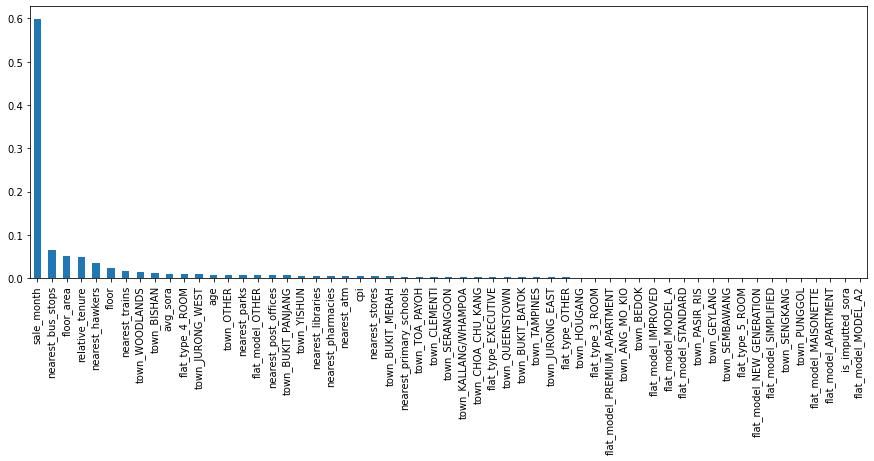

In [18]:
features_series = pd.Series(feature_impts.values(), index=feature_impts.keys())
features_series.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(15,5))
features_series.plot(kind = 'bar')
plt.show()

# Actual vs Predicted

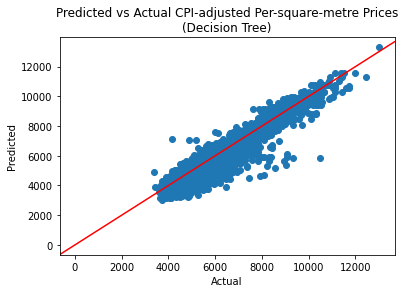

In [19]:
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1, color="red")
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(Decision Tree)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()